In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from classification_utils import ClassificationUtils
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

file_path = '../newData/Shifted_playoff.csv' 
df = pd.read_csv(file_path)

In [61]:
# Separazione dei dati di train (anni 1-9) e test (anno 10)
train_df = df[df['year'] < 10]
test_df = df[df['year'] == 11]

# Selezione delle feature e della variabile target
X_train = train_df.drop(columns=["PlayOffNextYear", "tmID", "year"])
y_train = train_df["PlayOffNextYear"]

X_test = test_df.drop(columns=["PlayOffNextYear", "tmID", "year"])
y_test = test_df["PlayOffNextYear"]  # Placeholder

# Scaling delle feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training Logistic Regression...


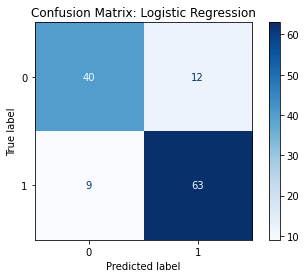

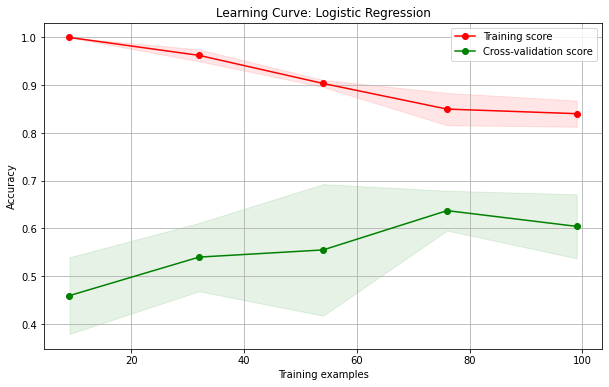

Training KNN...


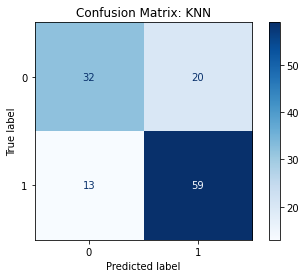

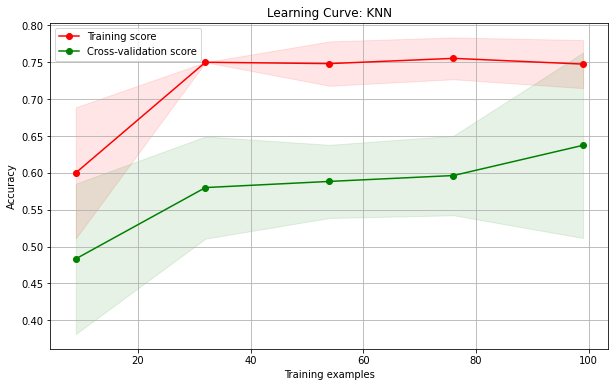

Training Random Forest...


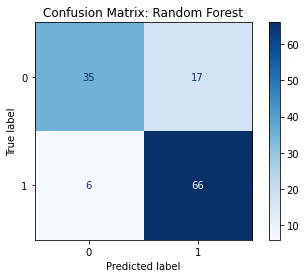

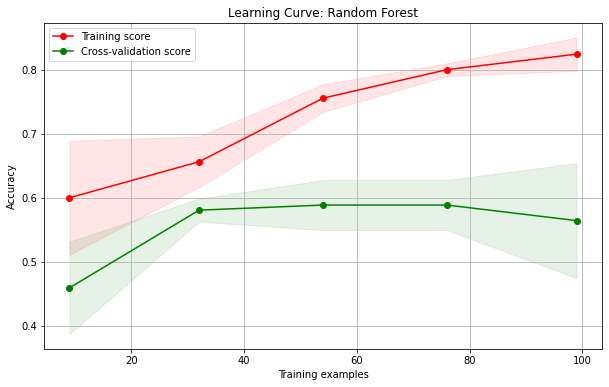

Training Naive Bayes...


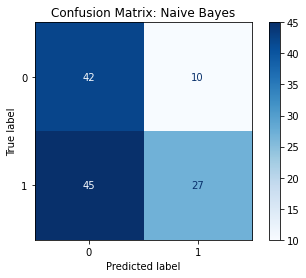

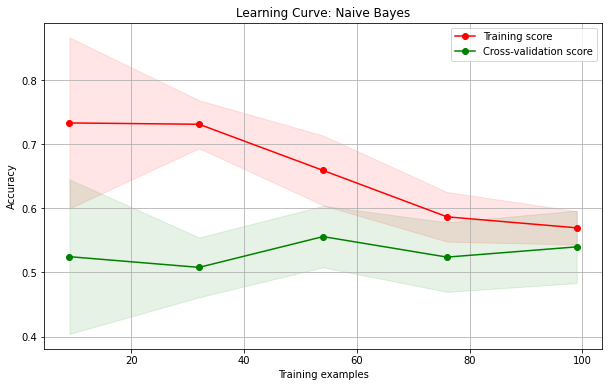

Training Decision Tree...


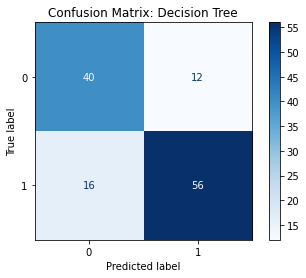

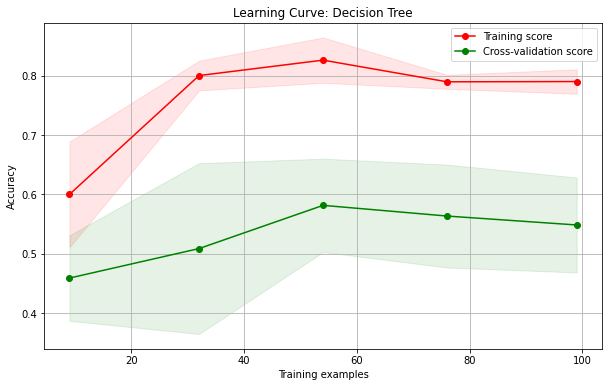

Training XGBoost with SMOTE-balanced dataset...


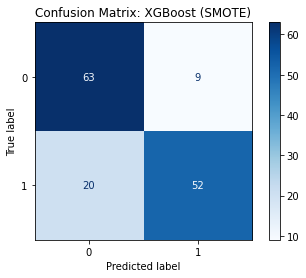

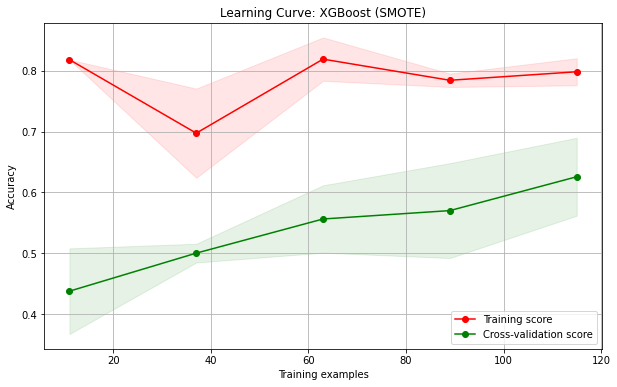

Training Gradient Boosting with SMOTE-balanced dataset...


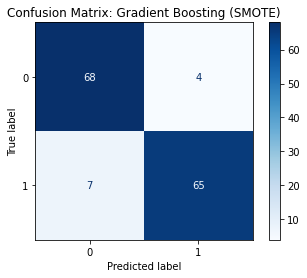

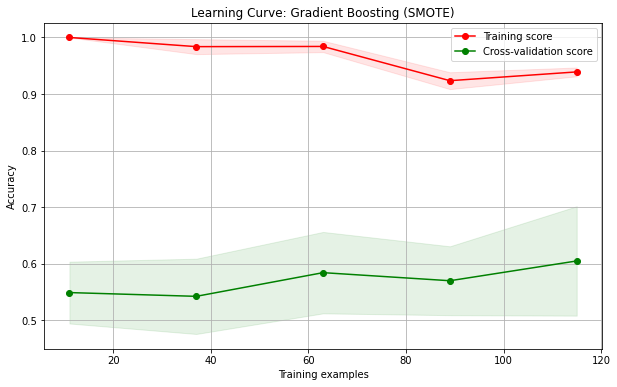

Training SVM...


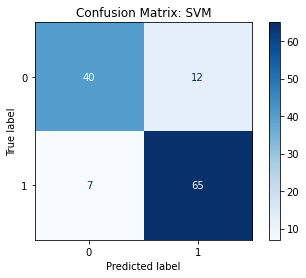

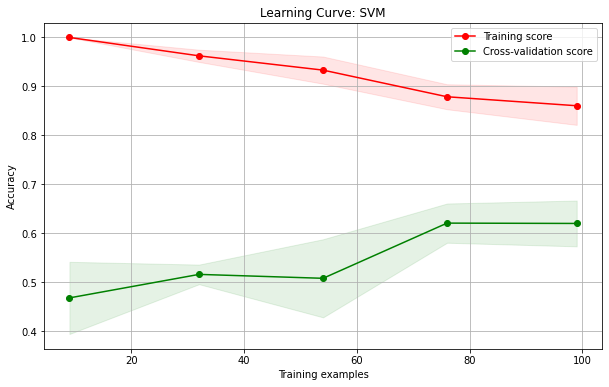

Model evaluation results:


,Accuracy,Precision,Recall,F1
Logistic Regression,0.830645,0.840000,0.875000,0.857143
KNN,0.733871,0.746835,0.819444,0.781457
Random Forest,0.814516,0.795181,0.916667,0.851613
Naive Bayes,0.556452,0.729730,0.375000,0.495413
Decision Tree,0.774194,0.823529,0.777778,0.800000
XGBoost (SMOTE),0.798611,0.852459,0.722222,0.781955
Gradient Boosting (SMOTE),0.923611,0.942029,0.902778,0.921986
SVM,0.846774,0.844156,0.902778,0.872483


In [62]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=5, min_samples_leaf=10),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_leaf=10),
    "XGBoost": XGBClassifier(max_depth=2, n_estimators=50, learning_rate=0.05, reg_lambda=15),
    "Gradient Boosting": GradientBoostingClassifier(max_depth=2, n_estimators=50, learning_rate=0.05),
    "SVM": SVC(kernel="linear", probability=True)
}

# Apply SMOTE for XGBoost and Gradient Boosting
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Metric calculation and plots
results = {}
for model_name, model in models.items():
    if model_name in ["XGBoost", "Gradient Boosting"]:
        # Training with SMOTE for XGBoost and Gradient Boosting
        print(f"Training {model_name} with SMOTE-balanced dataset...")
        model.fit(X_train_balanced, y_train_balanced)

        # Predictions on the SMOTE-balanced dataset
        predictions = model.predict(X_train_balanced)

        # Metric calculation
        accuracy = accuracy_score(y_train_balanced, predictions)
        precision = precision_score(y_train_balanced, predictions)
        recall = recall_score(y_train_balanced, predictions)
        f1 = f1_score(y_train_balanced, predictions)

        # Adding results
        results[f"{model_name} (SMOTE)"] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        }

        # Plots for models trained with SMOTE
        ClassificationUtils.plot_confusion_matrix(
            y_train_balanced, predictions, model_name=f"{model_name} (SMOTE)"
        )
        ClassificationUtils.plot_learning_curve(
            estimator=model,
            X=X_train_balanced,
            y=y_train_balanced,
            title=f"Learning Curve: {model_name} (SMOTE)",
            cv=5
        )
    else:
        # Training without SMOTE for other models
        print(f"Training {model_name}...")
        model.fit(X_train_scaled, y_train)

        # Predictions on the original dataset
        predictions = model.predict(X_train_scaled)

        # Metric calculation
        accuracy = accuracy_score(y_train, predictions)
        precision = precision_score(y_train, predictions)
        recall = recall_score(y_train, predictions)
        f1 = f1_score(y_train, predictions)

        # Adding results
        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        }

        # Plots for models trained without SMOTE
        ClassificationUtils.plot_confusion_matrix(
            y_train, predictions, model_name=model_name
        )
        ClassificationUtils.plot_learning_curve(
            estimator=model,
            X=X_train_scaled,
            y=y_train,
            title=f"Learning Curve: {model_name}",
            cv=5
        )

# Display results
results_df = pd.DataFrame(results).T
print("Model evaluation results:")
display(results_df)

### Cross-Validation Results
We perform 5-fold cross-validation to evaluate the generalization of each model. The mean accuracy and standard deviation across folds are presented below.


In [63]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Stratified Cross-Validation for XGBoost and Gradient Boosting
cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name in ["XGBoost", "Gradient Boosting"]:
    model = models[model_name]
    print(f"Performing stratified cross-validation for {model_name}...")
    
    # Perform stratified cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    
    # Store the results
    cv_results[model_name] = {
        "Mean Accuracy": scores.mean(),
        "Std Dev": scores.std()
    }

# Display cross-validation results
cv_results_df = pd.DataFrame(cv_results).T
print("Stratified Cross-Validation results for boosting models:")
display(cv_results_df)



# Cross-validation for XGBoost and Gradient Boosting
cv_results_boosting = {}

for model_name in ["XGBoost", "Gradient Boosting"]:
    model = models[model_name]
    print(f"Performing cross-validation for {model_name}...")
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Store the results
    cv_results_boosting[model_name] = {
        "Mean Accuracy": scores.mean(),
        "Std Dev": scores.std()
    }

# Display cross-validation results
cv_results_boosting_df = pd.DataFrame(cv_results_boosting).T
print("Cross-validation results for boosting models:")
display(cv_results_boosting_df)



Performing stratified cross-validation for XGBoost...
Performing stratified cross-validation for Gradient Boosting...
Stratified Cross-Validation results for boosting models:


,Mean Accuracy,Std Dev
XGBoost,0.580000,0.040000
Gradient Boosting,0.579333,0.087035


Performing cross-validation for XGBoost...
Performing cross-validation for Gradient Boosting...
Cross-validation results for boosting models:


,Mean Accuracy,Std Dev
XGBoost,0.573000,0.071805
Gradient Boosting,0.588667,0.063931


### Test Set Evaluation
Finally, we evaluate each model on the test set (Year 10) to assess their generalization performance.


In [64]:
# Predizione sui dati di test (anno 10)
test_results = {}
for model_name, model in models.items():
    print(f"Making predictions for {model_name} on Year 10...")

    # Training del modello
    model.fit(X_train_scaled, y_train)

    # Predizione delle probabilità
    probabilities = model.predict_proba(X_test_scaled)[:, 1]

    # Normalizzazione delle probabilità per rispettare il vincolo ∑ Y = 8
    normalized_probabilities = 8 * probabilities / probabilities.sum()

    # Aggiunta delle probabilità al test set
    test_df[f"{model_name}_Predicted_Probability"] = probabilities
    test_df[f"{model_name}_Normalized_Probability"] = normalized_probabilities

# Visualizzazione delle predizioni per ciascun modello
display(test_df)


Making predictions for Logistic Regression on Year 10...
Making predictions for KNN on Year 10...
Making predictions for Random Forest on Year 10...
Making predictions for Naive Bayes on Year 10...
Making predictions for Decision Tree on Year 10...
Making predictions for XGBoost on Year 10...
Making predictions for Gradient Boosting on Year 10...
Making predictions for SVM on Year 10...


<ipython-input-64-b3336b685552>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"{model_name}_Predicted_Probability"] = probabilities
<ipython-input-64-b3336b685552>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"{model_name}_Normalized_Probability"] = normalized_probabilities
<ipython-input-64-b3336b685552>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,year,tmID,confID,rank,playoff,o_fga,o_fta,o_3pa,o_oreb,o_dreb,...,Naive Bayes_Predicted_Probability,Naive Bayes_Normalized_Probability,Decision Tree_Predicted_Probability,Decision Tree_Normalized_Probability,XGBoost_Predicted_Probability,XGBoost_Normalized_Probability,Gradient Boosting_Predicted_Probability,Gradient Boosting_Normalized_Probability,SVM_Predicted_Probability,SVM_Normalized_Probability
2,11,ATL,0,0.201465,1.0,0.643561,-0.513151,-0.857842,0.737766,0.689176,...,1.089926e-05,1.459364e-05,0.736842,0.837568,0.528643,0.601922,0.601604,0.704172,0.633620,0.854583
13,11,CHI,0,0.817960,0.0,0.604334,-0.148443,-0.802304,0.680283,0.722586,...,2.134437e-06,2.857919e-06,0.866667,0.985139,0.574527,0.654166,0.698188,0.817222,0.654730,0.883054
27,11,CON,0,-0.820156,0.0,0.816491,0.122050,1.365881,0.698794,0.697192,...,9.747735e-01,1.305180e+00,0.400000,0.454680,0.511769,0.582709,0.568512,0.665438,0.569363,0.767918
56,11,IND,0,-0.045133,1.0,0.821095,2.394180,1.444918,0.747380,0.801103,...,9.992964e-01,1.338015e+00,0.105263,0.119653,0.554827,0.631735,0.550296,0.644116,0.545150,0.735260
67,11,LAS,1,-0.883567,1.0,0.780288,0.534470,0.438101,0.789709,0.929814,...,9.999995e-01,1.338956e+00,0.692308,0.786946,0.658034,0.749249,0.647755,0.758191,0.648815,0.875077
80,11,MIN,1,0.842620,0.0,0.912846,2.763192,0.472120,0.846692,0.889565,...,2.582354e-05,3.457661e-05,0.200000,0.227340,0.654562,0.745295,0.542456,0.634939,0.343202,0.462887
91,11,NYL,0,-0.341051,0.0,0.954745,1.493119,1.970477,0.840394,0.847468,...,1.000000e+00,1.338957e+00,0.200000,0.227340,0.636522,0.724755,0.529943,0.620293,0.446823,0.602643
102,11,PHO,1,0.250784,1.0,1.000000,3.551745,1.184655,0.931276,1.000000,...,1.000000e+00,1.338957e+00,0.866667,0.985139,0.597024,0.679782,0.708336,0.829100,0.262012,0.353383
125,11,SAS,1,0.307150,1.0,0.729508,0.129326,0.666798,0.557407,0.675612,...,3.022489e-04,4.046982e-04,0.736842,0.837568,0.554354,0.631197,0.553221,0.647539,0.424613,0.572688
136,11,SEA,1,0.004186,1.0,0.852571,1.734713,1.762506,0.806231,0.800230,...,1.000000e+00,1.338957e+00,0.866667,0.985139,0.658034,0.749249,0.687378,0.804569,0.521891,0.703890


### Prediction for Year 10 with Playoff Constraints

In this phase, we use the best model to:

1. Predict the probabilities of playoff qualification for the teams in Year 10.
2. Normalize the probabilities to ensure the sum equals 8.
3. Select the top 4 teams from each conference.
4. Add a label identifying the teams selected for the playoffs.

In [65]:
# Selected Model: Random Forest
best_model = RandomForestClassifier(max_depth=5, min_samples_leaf=10)
#best_model = SVC(kernel="linear", probability=True)
#best_model =LogisticRegression()

# Training the model
best_model.fit(X_train_scaled, y_train)

# Predicting probabilities for Year 10 qualification
probabilities = best_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1 (playoff)

# Adding probabilities to the test set (using loc to avoid warnings)
test_df = test_df.copy()  # Explicit copy
test_df.loc[:, "Predicted_Probability"] = probabilities

# Normalizing probabilities to satisfy the constraint ∑ Y = 8
normalized_probabilities = 8 * probabilities / probabilities.sum()
test_df.loc[:, "Normalized_Probability"] = normalized_probabilities

# Selecting the top 4 teams with the highest probabilities for East and West
east_teams = test_df[test_df["confID"] == 1].nlargest(4, "Normalized_Probability")
west_teams = test_df[test_df["confID"] == 0].nlargest(4, "Normalized_Probability")

# Combining the selected teams
playoff_teams = pd.concat([east_teams, west_teams])

# Adding a label to indicate which teams were selected for playoffs
test_df.loc[:, "Selected_Playoff"] = test_df["tmID"].isin(playoff_teams["tmID"]).astype(int)

# Displaying the selected playoff teams
print("Selected playoff teams:")
display(playoff_teams[["tmID", "confID", "Normalized_Probability"]])

# Displaying the complete DataFrame with probabilities and selection labels
print("Complete table with probabilities and selections:")
display(test_df[["tmID", "confID", "Predicted_Probability", "Normalized_Probability", "Selected_Playoff"]])


Selected playoff teams:


,tmID,confID,Normalized_Probability
67,LAS,1,0.808914
136,SEA,1,0.758215
102,PHO,1,0.753914
125,SAS,1,0.637909
91,NYL,0,0.764985
56,IND,0,0.710129
27,CON,0,0.701570
148,WAS,0,0.615856


Complete table with probabilities and selections:


,tmID,confID,Predicted_Probability,Normalized_Probability,Selected_Playoff
2,ATL,0,0.548470,0.597987,0
13,CHI,0,0.556243,0.606461,0
27,CON,0,0.643476,0.701570,1
56,IND,0,0.651327,0.710129,1
67,LAS,1,0.741932,0.808914,1
80,MIN,1,0.541125,0.589979,0
91,NYL,0,0.701639,0.764985,1
102,PHO,1,0.691486,0.753914,1
125,SAS,1,0.585087,0.637909,1
136,SEA,1,0.695430,0.758215,1
